# DELE CA2 Part C - Policy Comparison

In [1]:
# Run in Google Colab
# !apt-get install x11-utils > /dev/null 2>&1 
# !pip install pyglet > /dev/null 2>&1 
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install pyvirtualdisplay > /dev/null 2>&1
# !pip install gym==0.17.1 > /dev/null 2>&1
# !pip install wandb > /dev/null 2>&1

In [2]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

## Import Dependencies

In [3]:
# Data Manipulation Dependencies
import base64
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
from skimage.transform import resize

# Graphing Dependencies
import matplotlib.pyplot as plt

import gym
from gym.wrappers import Monitor

# Display Dependencies
from pyvirtualdisplay import Display
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython import display as ipython_display
from IPython.display import Video

# Deep Learning Dependencies
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.regularizers import *

# Miscellaneous Dependencies
import os
import io
import shutil
from warnings import filterwarnings

In [4]:
filterwarnings(action='ignore')

In [5]:
# display = Display(visible=False)
# display.start()

## Global Config

In [6]:
ARTIFACT_STORE = './artifacts/'
EPISODES = 1000
MAX_TIMESTEPS = 200

## General Utilities

In [7]:
from abc import ABC, abstractmethod

class Agent(ABC):
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            self.__setattr__(k, v)
    
    @abstractmethod
    def act(self, state):
        pass

In [ ]:
class FileLogger:
    def __init__(self, log_file: str, *args, sep: str=';'):
        self.log_file = log_file
        self.sep = sep
        self.n_args = len(args)
        if not os.path.exists(log_file):
            self.setup(args)
    
    def setup(self, args):
        header = self.sep.join(args)
        with open(self.log_file, mode='w') as f:
            f.write(header)
            f.write('\n')

    def log(self, **kwargs):
        assert len(kwargs) == self.n_args
        header = ''
        with open(self.log_file, mode='r') as f:
            header = f.readlines()[0].replace('\n', '')
        params = header.split(self.sep)
        values = (str(kwargs[p.lower()]) for p in params)
        entry = self.sep.join(values)
        with open(self.log_file, mode='a+') as f:
            f.write(entry)
            f.write('\n')
        return self

In [12]:
def train_agent(agent, artifact_store, episodes=100):
    shutil.rmtree(artifact_store + 'video', ignore_errors=True)
    os.mkdir(artifact_store + 'video')
    label = artifact_store.split('/')[2].capitalize()
    vid = VideoRecorder(env=env, path=artifact_store + f'video/CartPole-{label}.mp4')
    file_logger = FileLogger(artifact_store + 'progress.log', 'Episode', 'Total_Rewards')
    for episode in range(episodes):
        state = env.reset()
        total_rewards = 0
        for step in range(MAX_TIMESTEPS):
            print(f'\repisode {episode}; step {step}', end='')
            frame = env.render(mode='rgb_array')
            vid.capture_frame()

            action = agent.act(state)
            new_state, reward, done, _ = env.step(action=action)

            if done and step < MAX_TIMESTEPS - 1:
                reward = -10

            total_rewards += reward
            state = new_state

            if done:
                break
        file_logger.log(episode=episode, total_rewards=total_rewards)
    env.close()

In [13]:
def plot_learning_curve(log_file, sep, running_intervals=[]):
    df = pd.read_csv(log_file, sep=sep)
    episodes = df['Episode']
    scores = df['Total_Rewards']
    plt.plot(episodes, scores, label='Actual')
    for i in running_intervals:
        plt.plot(episodes, scores.rolling(window=i).mean(), label=f'{i}-Episode Running Mean')
    plt.legend()
    plt.show()

In [14]:
env = gym.make('CartPole-v0')

In [15]:
env.action_space

Discrete(2)

## Random Agent

### Agent Config

In [16]:
RANDOM_ARTIFACT_STORE = ARTIFACT_STORE + 'random/'

### Declare Agent

In [17]:
class RandomAgent(Agent):
    def __init__(self):
        super().__init__()
    
    def act(self, _):
        return np.random.randint(0, 2)

### Training

In [18]:
# train_agent(agent=RandomAgent(), artifact_store=RANDOM_ARTIFACT_STORE, episodes=1000)

### Plot Learning Curve

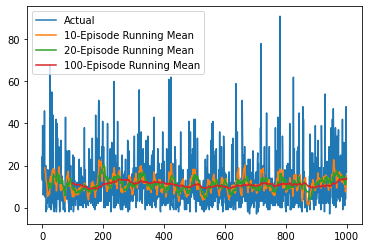

In [19]:
plot_learning_curve(log_file=RANDOM_ARTIFACT_STORE + 'progress.log', sep=';', running_intervals=[10, 20, 100])

### Preview Performance

In [20]:
Video('./artifacts/random/video/CartPole-Random.mp4')

## Angular Agent

In [21]:
ANGULAR_ARTIFACT_STORE = ARTIFACT_STORE + 'angular/'

### Declare Agent

In [22]:
class AngularAgent(Agent):
    def __init__(self):
        super().__init__()
    
    def act(self, state):
        return 1 if state.flatten()[2] > 0 else 0

### Train Agent

In [23]:
# train_agent(agent=AngularAgent(), artifact_store=ANGULAR_ARTIFACT_STORE)

### Plot Learning Curve

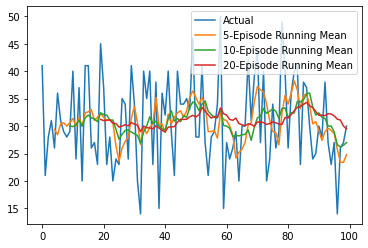

In [24]:
plot_learning_curve(ANGULAR_ARTIFACT_STORE + 'progress.log', sep=';', running_intervals=[5, 10, 20])

### Preview Performance

In [25]:
Video(ANGULAR_ARTIFACT_STORE + 'video/CartPole-Angular.mp4')

## Velocity Agent

In [26]:
VELOCITY_ARTIFACT_STORE = ARTIFACT_STORE + 'velocity/'

### Declare Agent

In [27]:
class VelocityAgent(Agent):
    def __init__(self):
        super().__init__()
    
    def act(self, state):
        return 1 if state.flatten()[3] > 0 else 0

### Train Agent

In [28]:
# train_agent(agent=VelocityAgent(), artifact_store=VELOCITY_ARTIFACT_STORE, episodes=50)

### Plot Learning Curve

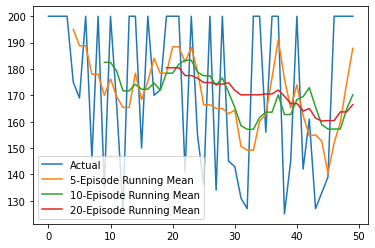

In [29]:
plot_learning_curve(log_file=VELOCITY_ARTIFACT_STORE + 'progress.log', sep=';', running_intervals=[5, 10, 20])

### Preview Performance

In [30]:
Video(VELOCITY_ARTIFACT_STORE + 'video/CartPole-Velocity.mp4')

## Angular + Velocity Agent

In [31]:
AV_ARTIFACT_STORE = ARTIFACT_STORE + 'av/'

### Declare Agent

In [32]:
class AVAgent(Agent):
    def __init__(self, threshold=0.03):
        super().__init__(threshold=threshold)
    
    def act(self, state):
        _, _, angle, velocity = state.flatten()
        if abs(angle) < self.threshold:
            return 1 if velocity > 0 else 0
        return 1 if angle > 0 else 0

### Train Agent

In [33]:
# train_agent(agent=AVAgent(), artifact_store=AV_ARTIFACT_STORE, episodes=10)

### Plot Learning Curve

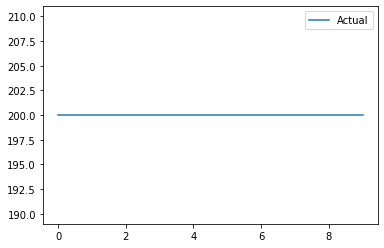

In [73]:
plot_learning_curve(AV_ARTIFACT_STORE + 'progress.log', sep=';')

### Preview Performance

In [35]:
Video(AV_ARTIFACT_STORE + 'video/CartPole-Av.mp4')

## Deep Q-Learning

In [8]:
class ReplayBuffer:
    def __init__(self, max_length: int):
        self.max_length = max_length
        self.buffer = [None] * self.max_length
        self.pointer = 0
        self.size = 0

    def append(self, memory):
        if self.pointer >= self.max_length:
            self.pointer = 0
        elif self.size < self.max_length:
            self.size += 1
        self.buffer[self.pointer] = memory
        self.pointer += 1

    def sample(self, batch_size: int):
        return [self.buffer[i] for i in  np.random.randint(0, self.size, batch_size)]
    
    def __getitem__(self, index):
        return self.buffer[index]
    
    def __len__(self):
        return self.size

In [9]:
class RewardTracker(deque):
    def __init__(self, max_length: int):
        super().__init__(maxlen=max_length)
        self.max_length = max_length

    def log(self, total_episodic_rewards):
        self.append(total_episodic_rewards)
    
    def get_rolling_mean(self):
        base = min(self.__len__(), self.max_length)
        return sum((r for r in self)) / float(base)

In [37]:
class DQN_Agent(Agent):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def calculate_target_values(self, memory_batch):
        states = []
        next_states = []
        for sample in memory_batch:
            states.append(sample[0])
            next_states.append(sample[3])
        states = np.array(states)
        next_states = np.array(next_states)

        q_values = self.model.predict(states)
        target_q_values = self.target_model.predict(states)

        q_values_next_state = self.model.predict(next_states)
        target_q_values_next_state = self.target_model.predict(next_states)

        targets = []
        for index, (s, a, r, s_, d) in enumerate(memory_batch):
            best_action = np.argmax(q_values_next_state[index])
            best_action_next_state_q_value = target_q_values_next_state[index][best_action]
            
            target_vector = [0, 0]
            target_vector[a] = r if d else r + self.gamma * best_action_next_state_q_value
            targets.append(target_vector)

        return states, np.array(targets)

    def act(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state.reshape(1, -1))[0])

    def learn(self):
        if len(self.replay_buffer) >= self.batch_size:
            samples = self.replay_buffer.sample(batch_size=self.batch_size)
            states, targets = self.calculate_target_values(samples)
            self.model.fit(states, targets, epochs=1, batch_size=targets.shape[0], verbose=0)
    
    def transfer_weights(self):
        policy_weights = self.model.get_weights()
        self.target_model.set_weights(policy_weights)
    
    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

## Deep Q-Learning (statistics)

In [38]:
STATS_ARTIFACT_STORE = ARTIFACT_STORE + 'stats/'

### Declare Agent

In [39]:
STATS_AGENT_CONFIG = {
    'batch_size': 64,
    'alpha': 0.01,
    'epsilon': 1.0,
    'min_epsilon': 0.01,
    'epsilon_decay': 0.99,
    'gamma': 0.995,
}

In [40]:
def DQN_Stats(input_shape, output_shape, alpha: float):
    model = Sequential(layers=[
        Input(shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(output_shape)
    ])
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=alpha))
    return model

In [41]:
class DQN_Stats_Agent(DQN_Agent):
    def __init__(self,
                 env,
                 batch_size: int,
                 alpha: float,
                 epsilon: float,
                 min_epsilon: float,
                 epsilon_decay: float,
                 gamma: float,
                 max_memory_length: int = 2000):
        super().__init__(
            env=env,
            batch_size=batch_size,
            alpha=alpha,
            epsilon=epsilon,
            min_epsilon=min_epsilon,
            epsilon_decay=epsilon_decay,
            gamma=gamma
        )
        self.replay_buffer = ReplayBuffer(max_length=max_memory_length)
        self.model = DQN_Stats(
            input_shape=env.observation_space.shape,
            output_shape=env.action_space.n,
            alpha=alpha)
        self.target_model = DQN_Stats(
            input_shape=env.observation_space.shape,
            output_shape=env.action_space.n,
            alpha=alpha)

In [42]:
def train_dqn_agent_stats():
    episodes = 1000
    target_model_train_interval = 10
    agent = DQN_Stats_Agent(env=env, **STATS_AGENT_CONFIG)
    vid = None
    os.mkdir(STATS_ARTIFACT_STORE + 'video')
    label = STATS_ARTIFACT_STORE.split('/')[2].capitalize()
    file_logger = FileLogger(STATS_ARTIFACT_STORE + 'progress.log', 'Episode', 'Total_Rewards')
    for episode in range(episodes):
        state = env.reset()
        total_rewards = 0
        if vid is None and episode >= 400:
            vid = VideoRecorder(env=env, path=STATS_ARTIFACT_STORE + f'video/CartPole-{label}.mp4')
        for step in range(MAX_TIMESTEPS):
            print(f'\repisode {episode}; step {step}', end='')
            if episode >= 400:
                frame = env.render(mode='rgb_array')
                vid.capture_frame()

            action = agent.act(state)
            new_state, reward, done, _ = env.step(action=action)

            if done and step < MAX_TIMESTEPS - 1:
                reward = -10
            
            agent.remember(state, action, reward, new_state, done)
            agent.learn()
            
            if episode % target_model_train_interval == 0:
                agent.transfer_weights()

            total_rewards += reward
            state = new_state

            if done:
                break

        file_logger.log(episode=episode, total_rewards=total_rewards)
        agent.decay_epsilon()
    env.close()

In [43]:
# train_dqn_agent_stats()

### Plot Learning Curve

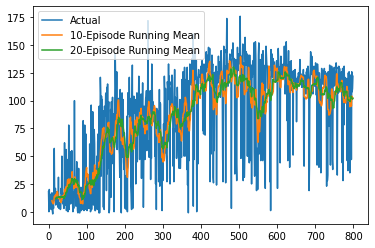

In [44]:
plot_learning_curve(log_file=STATS_ARTIFACT_STORE + 'progress.log', sep=';', running_intervals=[10, 20])

### Preview Performance

In [45]:
Video(STATS_ARTIFACT_STORE + 'video/CartPole-Stats.mp4')

## Deep Q-Learning (raw pixels)

### Pre-Processing

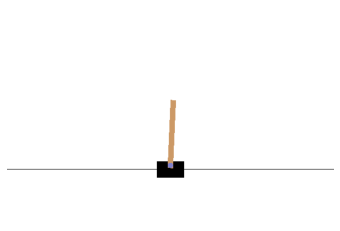

In [46]:
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(prev_screen)

In [47]:
env.action_space

Discrete(2)

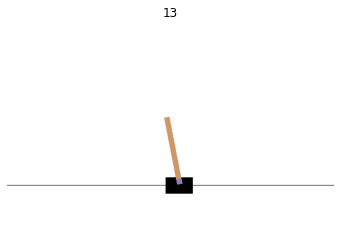

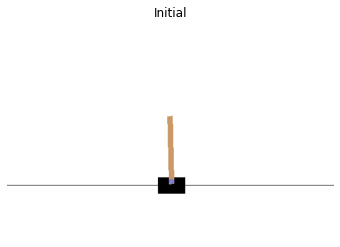

In [48]:
env.reset()

for step in range(100):
    screen = env.render(mode='rgb_array')
    plt.title(str(step))
    plt.imshow(screen)
    plt.axis('off')
    ipython_display.clear_output(wait=True)
    plt.show()
    
    action = env.action_space.sample() 
    state, reward, done, info = env.step(action)

    if done:
        np.argwhere(screen == 0)
        break

env.reset()
plt.title('Initial')
plt.imshow(env.render(mode='rgb_array'))
plt.axis('off')
env.close()

(400, 600, 3)


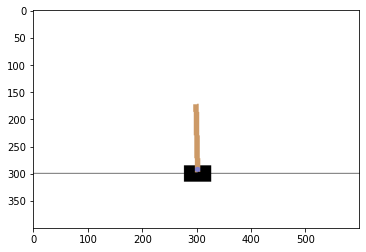

In [49]:
screen = env.render(mode='rgb_array')
print(screen.shape)
plt.imshow(screen)

(170, 300, 3)


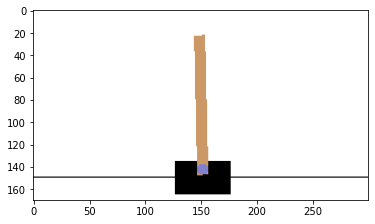

In [50]:
cropped_screen = screen[150:320, 150:450, :]
print(cropped_screen.shape)
plt.imshow(cropped_screen)

(170, 300)
(0.0, 254.97449999999998)


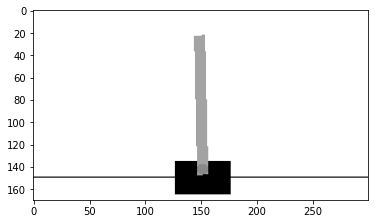

In [51]:
grayscale_cropped_screen = 0.2989 * cropped_screen[..., 0] + 0.5870 * cropped_screen[..., 1] + 0.1140 * cropped_screen[..., 2]
print(grayscale_cropped_screen.shape)
print((grayscale_cropped_screen.min(), grayscale_cropped_screen.max()))
plt.imshow(grayscale_cropped_screen, cmap='gray')

(0.0, 0.9999)


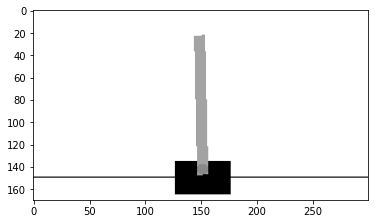

In [52]:
normalized_grayscale_cropped_screen = grayscale_cropped_screen.astype(np.float32) / 255.
print((normalized_grayscale_cropped_screen.min(), normalized_grayscale_cropped_screen.max()))
plt.imshow(normalized_grayscale_cropped_screen, cmap='gray')

(64, 64)


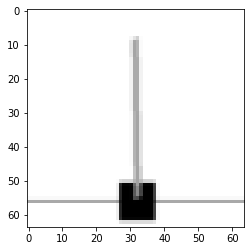

In [53]:
downresolutioned_normalized_grayscale_cropped_screen = resize(normalized_grayscale_cropped_screen, output_shape=(64, 64))
print(downresolutioned_normalized_grayscale_cropped_screen.shape)
plt.imshow(downresolutioned_normalized_grayscale_cropped_screen, cmap='gray')

(64, 64)


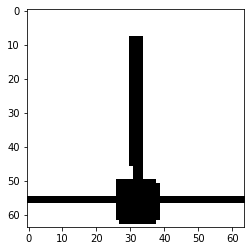

In [54]:
downresolutioned_normalized_bw_cropped_screen = downresolutioned_normalized_grayscale_cropped_screen.copy()
downresolutioned_normalized_bw_cropped_screen[downresolutioned_normalized_bw_cropped_screen < 0.99] = 0
print(downresolutioned_normalized_bw_cropped_screen.shape)
plt.imshow(downresolutioned_normalized_bw_cropped_screen, cmap='gray')

In [55]:
def preprocess_input(screen):
    cropped_screen = screen[150:320, 150:450, :]
    grayscale_cropped_screen = 0.2989 * cropped_screen[..., 0] + 0.5870 * cropped_screen[..., 1] + 0.1140 * cropped_screen[..., 2]
    normalized_grayscale_cropped_screen = grayscale_cropped_screen.astype(np.float32) / 255.
    downresolutioned_normalized_grayscale_cropped_screen = resize(normalized_grayscale_cropped_screen, output_shape=(64, 64))
    downresolutioned_normalized_bw_cropped_screen = downresolutioned_normalized_grayscale_cropped_screen.copy()
    downresolutioned_normalized_bw_cropped_screen[downresolutioned_normalized_bw_cropped_screen < 0.99] = 0
    return downresolutioned_normalized_bw_cropped_screen

In [56]:
def get_state(env):
    screen = env.render(mode='rgb_array')
    preprocessed_screen = preprocess_input(screen)
    expanded_screen = np.expand_dims(preprocessed_screen, 2)
    return expanded_screen

### Declare Agent

In [66]:
PIXELS_ARTIFACT_STORE = ARTIFACT_STORE + 'pixels/'

In [58]:
PIXELS_AGENT_CONFIG = {
    'batch_size': 64,
    'alpha': 0.0005,
    'epsilon': 1.0,
    'min_epsilon': 0.05,
    'epsilon_decay': 0.999,
    'gamma': 0.999
}

In [59]:
def DQN_Pixels(input_shape, output_shape, alpha: float):
    model = Sequential(layers=[
        Input(shape=input_shape),
        Conv2D(64, kernel_size=5, strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'),
        BatchNormalization(),
        Conv2D(64, kernel_size=4, strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'),
        BatchNormalization(),
        Conv2D(64, kernel_size=2, strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'),
        BatchNormalization(),
        Flatten(),
        Dense(output_shape)
    ])
    model.compile(loss=Huber(), optimizer=RMSprop(learning_rate=alpha))
    return model

In [60]:
class DQN_Pixels_Agent(Agent):
    def __init__(self,
                 env,
                 batch_size: int,
                 alpha: float,
                 epsilon: float,
                 min_epsilon: float,
                 epsilon_decay: float,
                 gamma: float,
                 max_memory_length: int = 200_000,
                 checkpoint_interval: int = 10):
        self.env = env
        self.batch_size = batch_size
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.replay_buffer = ReplayBuffer(max_length = max_memory_length)
        self.model = DQN_Pixels(input_shape=(64, 64, 1),
                         output_shape=env.action_space.n,
                         alpha=alpha)
    
    def act(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state.reshape(1, 64, 64, 1))[0])
    
    def calculate_target_values(self, memory_batch):
        states = []
        next_states = []
        for sample in memory_batch:
            states.append(sample[0])
            next_states.append(sample[3])
        states = np.array(states)
        next_states = np.array(next_states)

        q_values = self.model.predict(states)
        q_values_target = q_values.copy()

        q_values_next_state = self.model.predict(next_states)

        for index, (s, a, r, s_, d) in enumerate(memory_batch):
            best_action = np.max(q_values_next_state[index])
            q_values_target[index, a] = r if d else r + self.gamma * best_action

        return states, q_values_target

    def learn(self):
        if len(self.replay_buffer) >= self.batch_size:
            samples = self.replay_buffer.sample(batch_size=self.batch_size)
            states, targets = self.calculate_target_values(samples)
            self.model.fit(states, targets, epochs=1, batch_size=targets.shape[0], verbose=0)
            self.decay_epsilon()
    
    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

In [61]:
def train_dqn_agent_pixels():
    episodes = 1000
    target_model_train_interval = 10
    agent = DQN_Pixels_Agent(env=env, **PIXELS_AGENT_CONFIG)
    vid = None
    os.mkdir(PIXELS_ARTIFACT_STORE + 'video')
    label = PIXELS_ARTIFACT_STORE.split('/')[2].capitalize()
    file_logger = FileLogger(PIXELS_ARTIFACT_STORE + 'progress.log', 'Episode', 'Total_Rewards')
    for episode in range(episodes):
        env.reset()
        prev_screen = get_state(env)
        current_screen = get_state(env)
        state = current_screen - prev_screen
        total_rewards = 0
        if vid is None and episode >= 400:
            vid = VideoRecorder(env=env, path=PIXELS_ARTIFACT_STORE + f'video/CartPole-{label}.mp4')
        for step in range(MAX_TIMESTEPS):
            print(f'\repisode {episode}; step {step}', end='')
            if episode >= 400:
                frame = env.render(mode='rgb_array')
                vid.capture_frame()

            action = agent.act(state)
            _, reward, done, _ = env.step(action=action)

            current_screen = get_state(env)

            new_state = current_screen - prev_screen

            if done and step < MAX_TIMESTEPS - 1:
                reward = -10
            
            agent.remember(state, action, reward, new_state, done)
            agent.learn()
            
            total_rewards += reward
            state = new_state

            if done:
                break

        file_logger.log(episode=episode, total_rewards=total_rewards)
    env.close()

In [63]:
# train_dqn_agent_pixels()

episode 999; step 14

### Plot Learning Curve

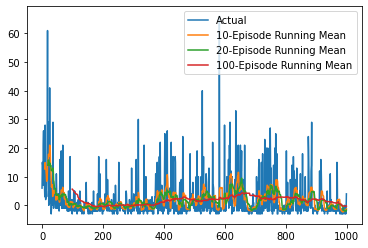

In [70]:
plot_learning_curve(log_file=PIXELS_ARTIFACT_STORE + 'progress.log', sep=';', running_intervals=[10, 20, 100])

### Preview Performance

In [72]:
Video(PIXELS_ARTIFACT_STORE + 'video/CartPole-Pixels.mp4')